In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("ion_predictor")


In [3]:
from ion_predictor.ml import pretrain_descriptors 
from ion_predictor.ml.auto_trainer import auto_prepare_model
from ion_predictor.ml.NeuralDescriptor import NeuralDescriptor
import yaml
import joblib

setting_path="config/settings.yaml"

with open(setting_path) as file:
    settings= yaml.safe_load(file)


Using backend: pytorch


In [154]:
#dump pretraining descriptor data from SMILES data
pretrain_descriptors.dump(settings)

100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/dgl/base.py:45: DGLWarn

Epoch 20, loss 0.6565


Epoch 40, loss 0.7016


Epoch 60, loss 0.6126


Epoch 80, loss 0.5401


Epoch 100, loss 0.5554


Epoch 120, loss 0.5360


Epoch 140, loss 0.5506


Epoch 160, loss 0.5424


Epoch 180, loss 0.5157


100%|██████████| 200/200 [00:07<00:00, 25.05it/s]

Epoch 200, loss 0.4852


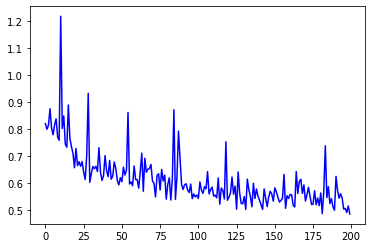

In [155]:
#train gnn model
auto_prepare_model(settings)

In [4]:
from ion_predictor.composite.auto_data_preparer import load_ion_excel
parsed_df=load_ion_excel(settings)

/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [5]:
y_label=settings["y_label"]

In [6]:
from ion_predictor.ml.regressor import initiate_regressor
from ion_predictor.ml.dataset_utils import get_number_and_category_cols 

number_columns,category_columns=get_number_and_category_cols(parsed_df,y_label)
model=initiate_regressor(number_columns,category_columns)

In [7]:
X=parsed_df.drop([y_label,"ID"],axis=1)
X=X.sort_index(axis=1, ascending=False)
y=parsed_df[[y_label]]
X_columns=list(X.columns)

In [8]:
model.fit(X,y)
joblib.dump([model,X_columns],settings["regressor_path"])

/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


['cache/regressor.bin']

In [14]:
import numpy as np
test_df=load_ion_excel(settings,composite_sheet_name="DatabaseForTest")
test_X=test_df.drop([y_label,"ID"],axis=1)
test_y=test_df[[y_label]]

lacking_columns=set(X_columns)-set(test_X.columns)
for c in lacking_columns:
    test_X[c]=np.nan
test_X=test_X.sort_index(axis=1, ascending=False)

/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [15]:
pred_y=model.predict(test_X)

/home/user/anaconda3/envs/mi/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Text(-10, -1, 'MAE: 0.71')

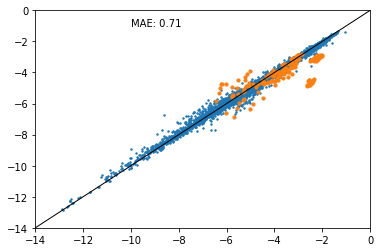

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score


ax=plt

model.fit(X,y)
pred_train_y=model.predict(X)
pred_test_y=model.predict(test_X)

ax.scatter(y,pred_train_y,s=2)
ax.scatter(test_y,pred_test_y,s=10)
plt.xlim(-14,0)
plt.ylim(-14,0)
ax.plot((-14,0),(-14,0),c="black",linewidth=1)

test_mae=mean_absolute_error(test_y,pred_test_y)
ax.text(-10,-1,f"MAE: {test_mae:.2f}")